# Clustering - Customer Segmentation with K-Means
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: 
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: 
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: 


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms 

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_palette("bright")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [10]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [11]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [12]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

Creating a data frame where each row has the following columns:
     - customer_name
     - One column for each offer, with a 1 if the customer responded to the offer
     - `NaN`will be converted to 0.

In [13]:
df = pd.merge(df_offers, df_transactions)
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.fillna(0,inplace = True)
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

With K-Means Clustering, we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters - K. We will use the following methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

We will create a numpy matrix `x_cols` with only the columns representing the offers.
We will then apply the [`KMeans`] clustering method from scikit-learn to this matrix. 
A bar chart will be produced showing the number of points in each cluster for k-means under the best $K$.
Plots for $SS$ for each $K$ will be created and $K$ will be picked using this plot. For simplicity, we will test $2 \le K \le 10$.


In [14]:
brian = matrix.reset_index()

x_cols = brian.drop('customer_name', axis=1)

matrix[matrix.columns[2:]].head()

offer_id,3,4,5,6,7,8,9,10,11,12,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


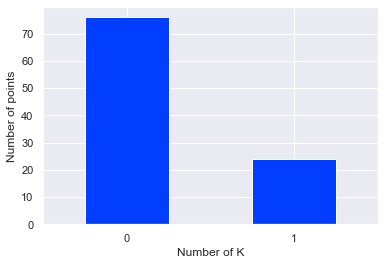

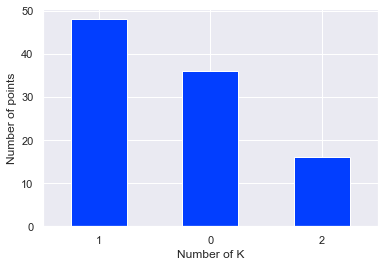

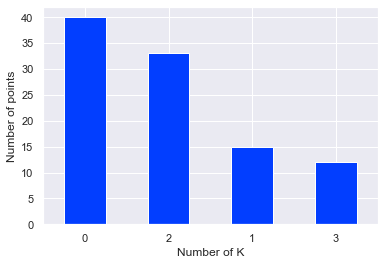

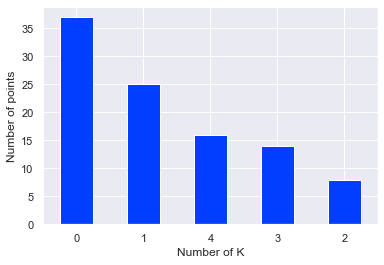

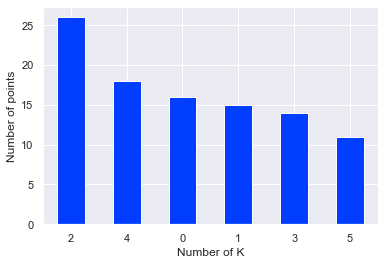

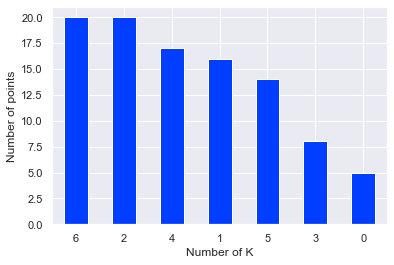

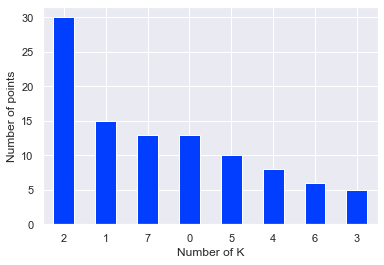

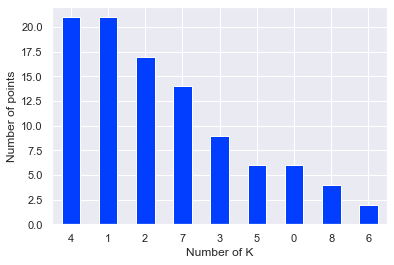

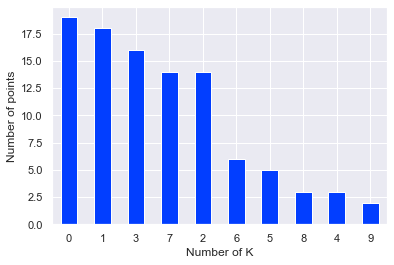

In [7]:
slicer=[]

for i in range(2,11):
    cluster = KMeans(n_clusters=i)
    matrix['cluster'] = cluster.fit_predict(matrix)
    slicer.append(cluster.inertia_)
    bar = matrix['cluster'].value_counts()
    matrix.drop('cluster', axis = 1, inplace = True)
    bar.plot(kind ='bar', rot=0)
    plt.xlabel("Number of K")
    plt.ylabel("Number of points")
    plt.show()

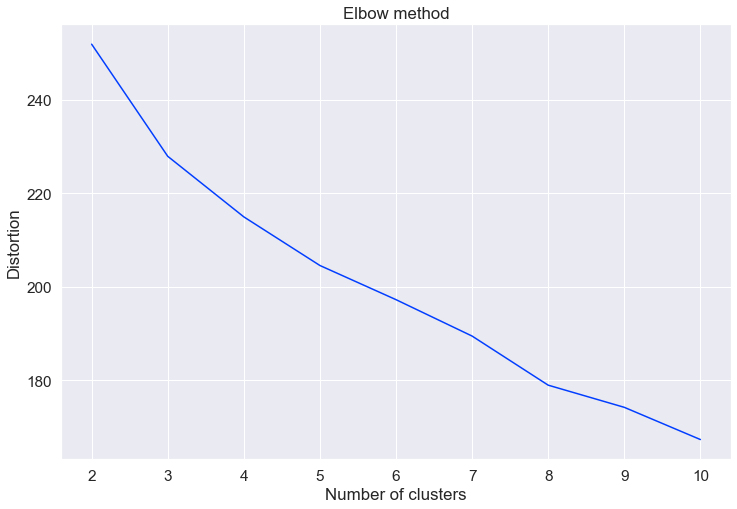

In [8]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.set_palette("bright")

sns.lineplot(x=range(2,11), y=slicer)
plt.xticks(range(2,11))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

If k increases, average distortion will decrease and the instances will be closer to their respective centroids. However, the improvements in average distortion will decline as k increases. The value of k at which improvement in distortion declines the most is called the elbow, at which we should stop dividing the data into further clusters.  The elbow is not very distinct meaning that this may not be a good way to determine the number of clusters.  The data may be too evenly distributed.  

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn.

We are going to construct a series of silhouette plots and compute the average silhouette score for each $K$ and plot that. 

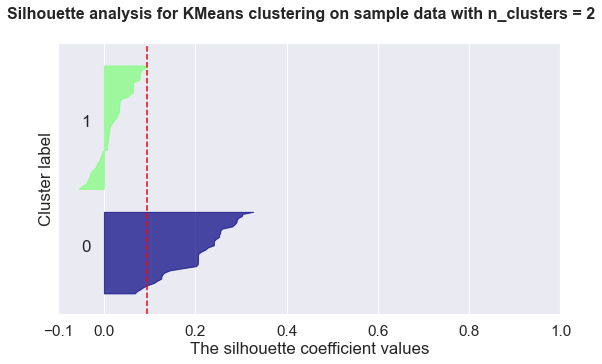

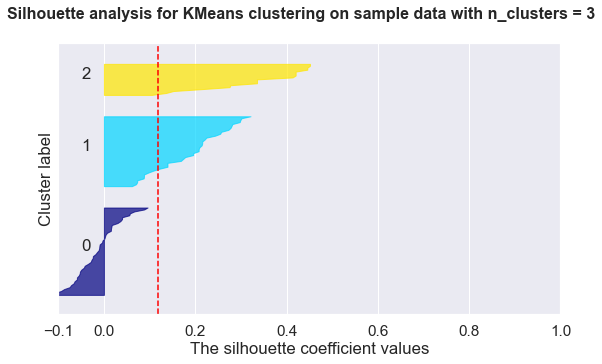

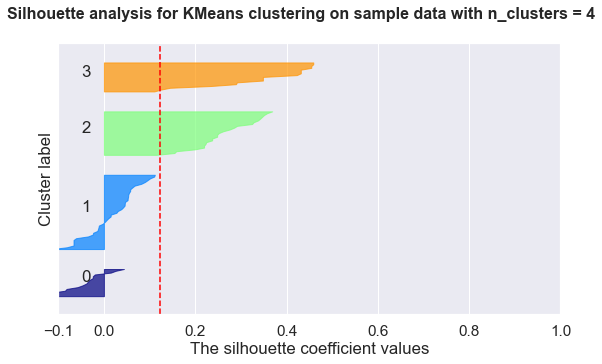

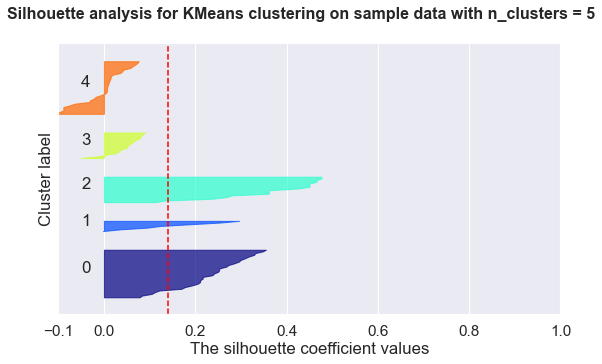

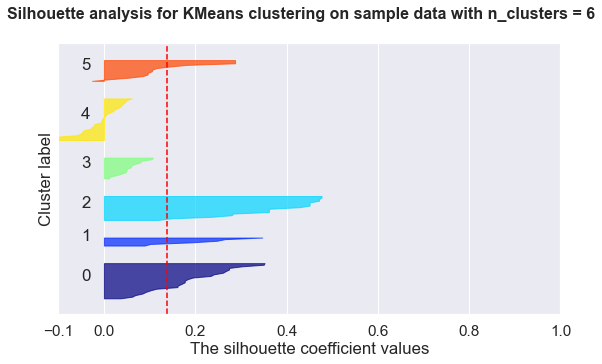

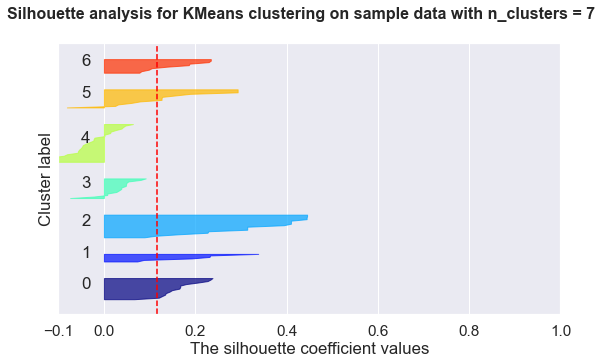

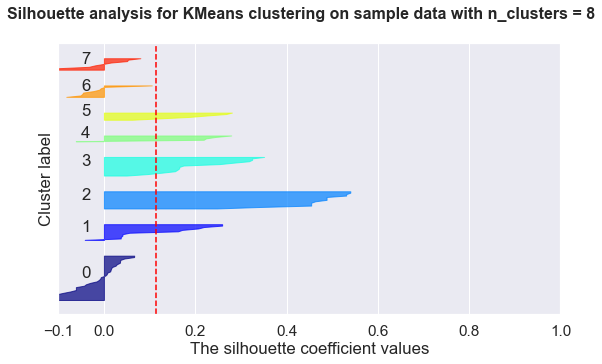

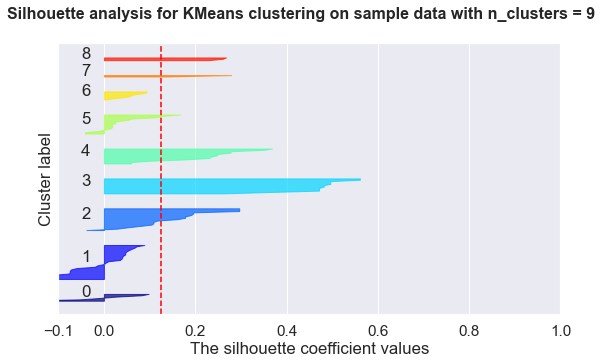

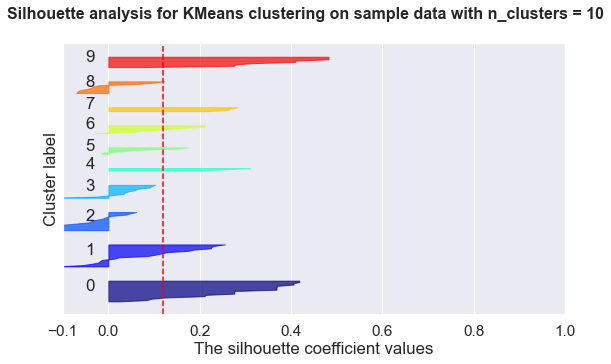

In [16]:
# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

K_ranger = list(range(2, 11))
X = x_cols.to_numpy()

for k in K_ranger:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)
    
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("jet")
        color = cm.jet(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=16, fontweight='bold')

In [48]:
silhouette = []
for i in range(2,11):
    cluster = KMeans(n_clusters=i)
    preds = cluster.fit_predict(matrix)
    score = silhouette_score(matrix, preds)
    silhouette.append(score)
    print(score)

0.09174871508750351
0.1176998005869721
0.1176300961165422
0.12964085347643095
0.1276545675729835
0.1133906536410434
0.12019300675657986
0.12042348130917055
0.13339325400936328


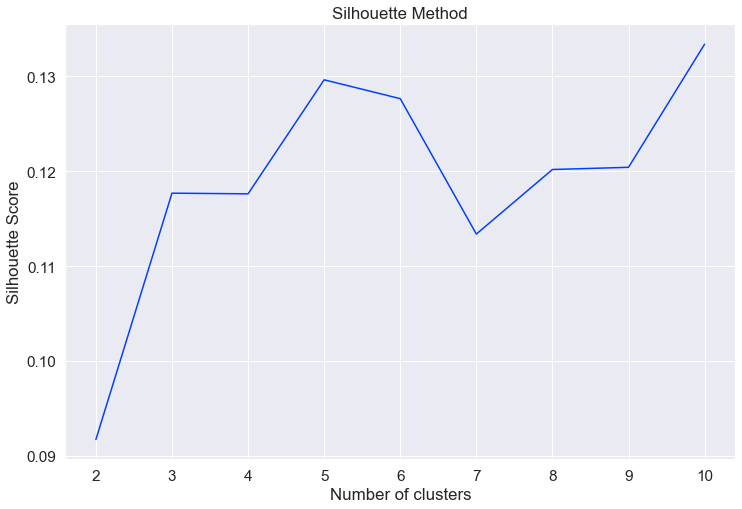

In [49]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.set_palette("bright")

sns.lineplot(x=range(2,11), y=silhouette)
plt.xticks(range(2,11))
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [50]:
cluster = KMeans(n_clusters=3)
matrix['cluster'] = cluster.fit_predict(matrix)

These numbers of clusters all produce really bad silhouette scores.  5 clusters may be the best but no substantial structure has been found yet.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimensionality reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Use PCA to plot the clusters:**


Use scikit-learn's [`PCA`] function to reduce the dimensionality of your clustering data to 2 components
We are going to create a data frame with the following fields:
  
  -customer name
  
  -cluster id the customer belongs to
  
  -the two PCA components (label them `x` and `y`)
  
  Then, we will plot a scatterplot of the `x` vs `y` columns and color-code points differently based on cluster ID
  
  
  How do the clusters look? 
  Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?


Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [51]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,0,1.014908,0.157764
1,Allen,2,-0.313043,0.019268
2,Anderson,1,-0.451462,1.008114
3,Bailey,0,0.700551,0.006002
4,Baker,2,0.072574,-0.494352


In [52]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,2,-0.885247,0.183565
1,1,January,Malbec,72,56,France,False,Jackson,1,2,-0.668236,-0.259736
2,1,January,Malbec,72,56,France,False,Mitchell,1,2,-0.202992,0.375711
3,1,January,Malbec,72,56,France,False,Peterson,1,1,-0.659017,0.535507
4,1,January,Malbec,72,56,France,False,Wood,1,2,-0.398641,-0.339148


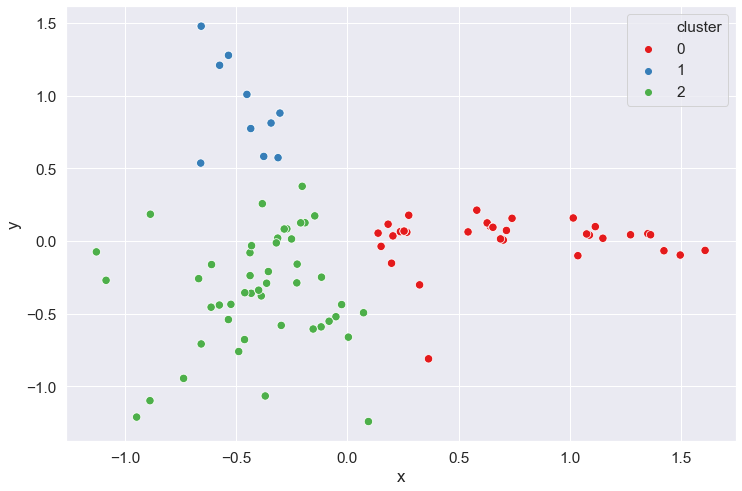

In [63]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)

sns.scatterplot(x='x', y='y', 
                hue='cluster', data = matrix, palette = "Set1", s = 70)
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

Since we wanted to visualize our data in 2 dimensions, we restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?

Using a new PCA object, we will plot the `explained_variance_` field and look for the elbow point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions.


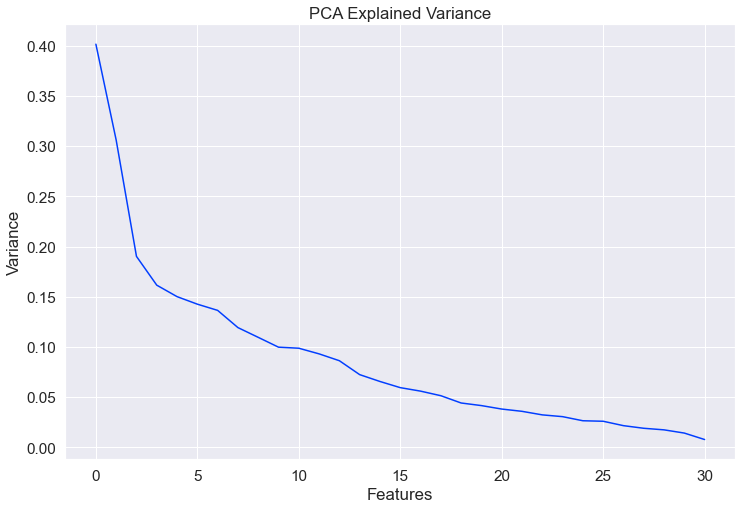

In [66]:
# Initialize a new PCA model with a default number of components.

pca = sklearn.decomposition.PCA()
pca.fit(matrix[x_cols])

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.set_palette("bright")

sns.lineplot(data = pca.explained_variance_)

plt.title('PCA Explained Variance')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.show()


It appears from this plot that 3 dimensions may be ideal for this data set.

## 4. Conclusions and next steps

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

<div class="span5 alert alert-info">

<p><b>We will try clustering using the following algorithms.</b></p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>

</div>


In [67]:
pca = sklearn.decomposition.PCA(n_components=2)
X = pca.fit_transform(matrix[x_cols])

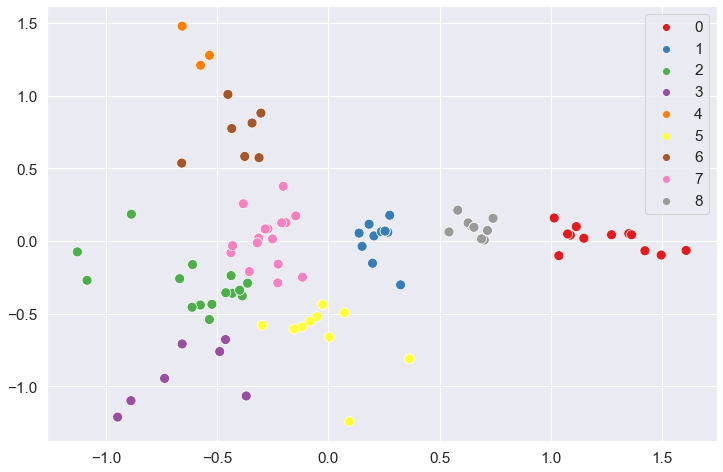

In [72]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(random_state = None).fit(X)
clustering.labels_


plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)

sns.scatterplot(x=X[:,0], y=X[:,1], 
                hue=clustering.labels_, data = matrix, palette = "Set1", s = 100)
plt.show()

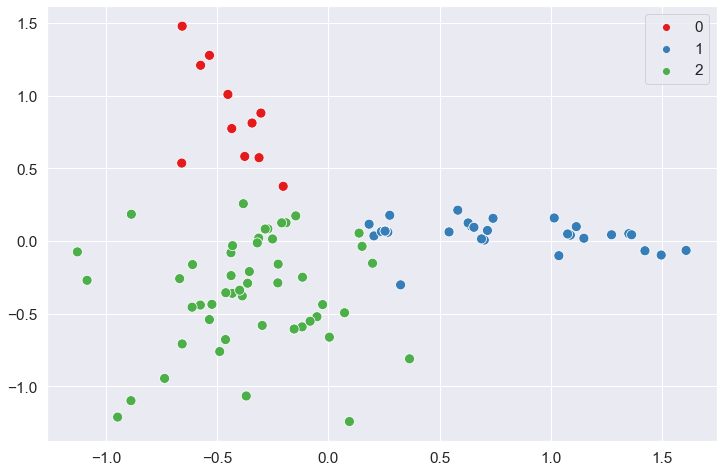

In [73]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0).fit(X)
clustering.labels_

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)

sns.scatterplot(x=X[:,0], y=X[:,1], 
                hue=clustering.labels_, data = matrix, palette = "Set1", s = 100)
plt.show()

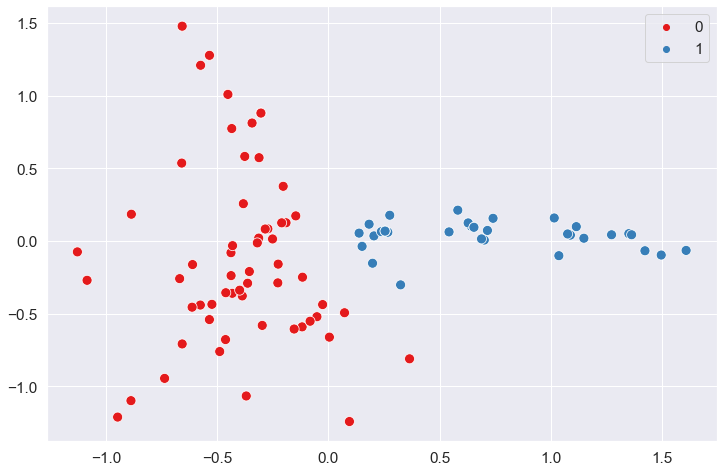

In [75]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(X)
clustering.labels_

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)

sns.scatterplot(x=X[:,0], y=X[:,1], 
                hue=clustering.labels_, data = matrix, palette = "Set1", s = 100)
plt.show()

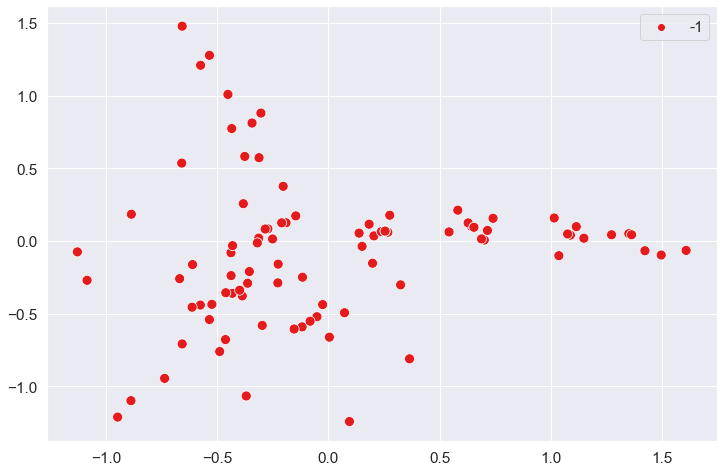

In [94]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5, min_samples=50, n_jobs=-1, metric='l2').fit(X)
clustering.labels_

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)

sns.scatterplot(x=X[:,0], y=X[:,1], 
                hue=clustering.labels_, data = matrix, palette = "Set1", s = 100)
plt.show()

Agglomerative clustering and DBSCAN would not be good here as the number of samples are just over 300 and these methods are designed for very large sample sizes. Spectral clustering produces good results but the results are essentially the same as what we saw with k-means clusters using PCA.  The method of choice would be Affinity Propagation because we do not really know how many clusters we have and there looks to be some uneven sizes in the KMeans with PCA and Spectral clustering outputs. "In Affinity Propagation, the data points can be seen as a network where all the data points send messages to all other points. The subject of these messages are the willingness of the points being exemplars. Exemplars are points that explain the other data points ‘best’ and are the most significant of their cluster. A cluster only has one exemplar. All the data points want to collectively determine which data points are an exemplar for them."  Since the Silhouette Method found no substantial structure and Spectral clustering produced output that was very similar to KMeans with PCA and an elbow method found no conclusive number of k indicating an even distribution, Affinity Propagation may be ideal as it determines the number of k without needing to know k in advance and uses similarity of the points to determine number of clusters (k).  More on Affinity Propagation can be found [here](https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/).